In [1]:
import torch
import numpy as np
import pandas as pd
from sbi.analysis import pairplot
from sbi.inference import SNPE, simulate_for_sbi, SNLE
from sbi.utils import BoxUniform
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)
import matplotlib.pyplot as plt
from simulator import Market
import yfinance as yf

In [2]:
def simulator_base(prior_sample):
    #access the first prior value from the tensor
    #create a dcitionary with the prior sample
    params = {"theta_sigma": float(prior_sample[0]), 
              "gamma_sigma": float(prior_sample[1])}
    #run the market simulation
    market = Market(params)
    while market.step_count < market.total_steps:
        market.next_step()
    #compute the financial market return
    market_return = np.asarray(market.history_p_t)[1:]/np.asarray(market.history_p_t)[:-1] - 1
    # compute the variance, skewness and kurtosis of the market return
    variance = np.var(market_return)
    skewness = np.mean(((market_return - np.mean(market_return)) / np.std(market_return)) ** 3)
    kurtosis = np.mean(((market_return - np.mean(market_return)) / np.std(market_return)) ** 4)
    

    return torch.tensor([skewness, kurtosis])

In [3]:
#pick the true parameters
theta_sigma = 1
gamma_sigma = 1
theta_sigma_bounds = [0.1, 4]
gamma_sigma_bounds = [0.1, 4]

In [4]:
num_dim = 2
num_rounds = 2
# The specific observation we want to focus the inference on.
x_o = simulator_base([theta_sigma, gamma_sigma])

prior = BoxUniform(low=torch.tensor([theta_sigma_bounds[0], gamma_sigma_bounds[0]]),
                    high=torch.tensor([theta_sigma_bounds[1], gamma_sigma_bounds[1]]))

# Ensure compliance with sbi's requirements.
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator_base, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)

inference = SNPE(prior)
proposal = prior

for _ in range(num_rounds):
    theta = proposal.sample((10,))
    x = simulator(theta)
    _ = inference.append_simulations(theta, x).train()
    posterior = inference.build_posterior(mcmc_method="slice_np_vectorized",
                                          mcmc_parameters={"num_chains": 20,
                                                           "thin": 5})
    proposal = posterior.set_default_x(x_o)


 Neural network successfully converged after 120 epochs.

Drawing 10 posterior samples:   0%|          | 0/10 [00:00<?, ?it/s]

AssertionError: You have already trained this neural network. After you had trained the network, you again appended simulations with `append_simulations(theta, x)`, but you did not provide a proposal. If the new simulations are sampled from the prior, you can set `.train(..., force_first_round_loss=True`). However, if the new simulations were not sampled from the prior, you should pass the proposal, i.e. `append_simulations(theta, x, proposal)`. If your samples are not sampled from the prior and you do not pass a proposal and you set `force_first_round_loss=True`, the result of SNPE will not be the true posterior. Instead, it will be the proposal posterior, which (usually) is more narrow than the true posterior.

In [10]:
# 2 rounds: first round simulates from the prior, second round simulates parameter set
# that were sampled from the obtained posterior.
num_rounds = 2
num_dim = 2
# The specific observation we want to focus the inference on.
x_o = simulator_base([theta_sigma, gamma_sigma])

prior = BoxUniform(low=torch.tensor([theta_sigma_bounds[0], gamma_sigma_bounds[0]]),
                    high=torch.tensor([theta_sigma_bounds[1], gamma_sigma_bounds[1]]))

# Ensure compliance with sbi's requirements.
prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(simulator_base, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)

inference = SNPE(prior)

posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=50)

    # In `SNLE` and `SNRE`, you should not pass the `proposal` to
    # `.append_simulations()`
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    #posterior = inference.build_posterior(mcmc_method="slice_np_vectorized",
    #                                      mcmc_parameters={"num_chains": 20,
    #                                                       "thin": 5})
    proposal = posterior.set_default_x(x_o)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

 Neural network successfully converged after 192 epochs.

Drawing 50 posterior samples:   0%|          | 0/50 [00:00<?, ?it/s]

Running 50 simulations.:   0%|          | 0/50 [00:00<?, ?it/s]

Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

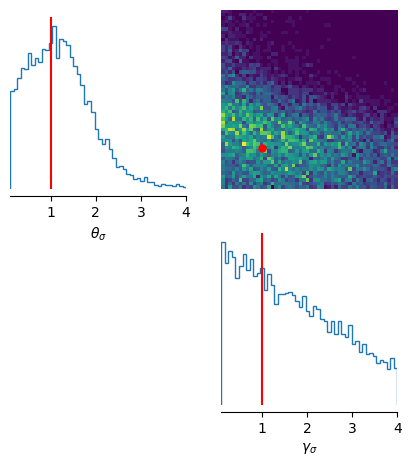

In [11]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
fig, ax = pairplot(
    posterior_samples, limits=[theta_sigma_bounds, gamma_sigma_bounds], figsize=(5, 5),
    points=[np.array([theta_sigma, gamma_sigma])],
                      points_colors='r', labels=[r'$\theta_{\sigma}$', r'$\gamma_{\sigma}$']
)

In [12]:
# Check the posterior
posterior_df = pd.DataFrame(posterior_samples.numpy(), columns=["theta_sigma", "gamma_sigma", "epsilon_sigma", "ar_1_coefficient"])
posterior_df.describe()

ValueError: Shape of passed values is (10000, 2), indices imply (10000, 4)

In [13]:
implied_data = simulator_base([theta_sigma, gamma_sigma, epsilon_sigma, ar_1_coefficient]).numpy()

#compute skew and kurtosis of the implied data
skew = pd.Series(implied_data).skew()
kurt = pd.Series(implied_data).kurt()

#compare with skew and kurtosis of the true data
true_data_skew = pd.Series(x_o.numpy().flatten()).skew()
true_data_kurt = pd.Series(x_o.numpy().flatten()).kurt()

print("Skewness of the true data: ", true_data_skew)
print("Kurtosis of the true data: ", true_data_kurt)
print("Skewness of the implied data: ", skew)
print("Kurtosis of the implied data: ", kurt)

Skewness of the true data:  0.08863496350312629
Kurtosis of the true data:  0.9451114760392829
Skewness of the implied data:  0.07821622077325903
Kurtosis of the implied data:  1.2978417839235505


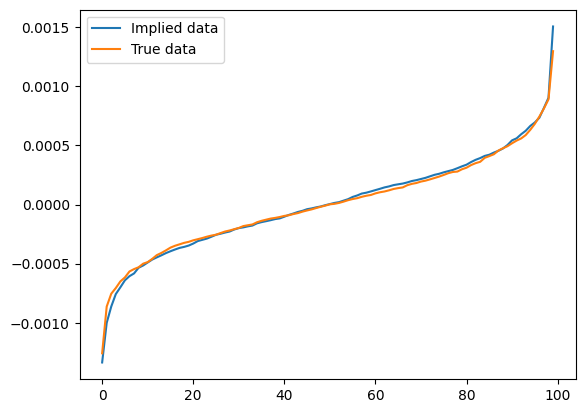

In [14]:
#plot the implied data and the true data
plt.plot(implied_data, label="Implied data")
plt.plot(x_o.numpy().flatten(), label="True data")
#show labels
plt.legend()

In [18]:
# get the data for the stock AAPL, on a daily basis
data = yf.download('AAPL','2016-01-01','2021-01-01')
#compute returns 
data['Return'] = data['Adj Close'].pct_change()

real_data = torch.tensor(np.percentile(data.Return.values, np.linspace(0, 100, 100)))


[*********************100%%**********************]  1 of 1 completed


In [19]:
# estimate on real data
estimates = posterior.sample((1000,), x=real_data)


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

                    accepted. It may take a long time to collect the remaining
                    1000 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.


KeyboardInterrupt: 